The pokereval library can be installed [here](https://sourceforge.net/projects/fpdb/files/fpdb/pypoker-eval-win32/).

In [1]:
import os
import pokereval
import numpy as np
#import scipy.misc
import scipy.special
# % indicates an ipython commnand
%pylab inline 

Populating the interactive namespace from numpy and matplotlib


In [2]:
pe = pokereval.PokerEval()

In [3]:
# ? lets you access documentation for functions in jupyter
pokereval.PokerEval?

In [3]:
numCards = 52
numRanks = 13
numSuits = 4
numHands = 1326 # nchoosek(52,2)
numVillainHands = 1225 # nchoosek(50,2)

suits = ['h', 'd', 'c', 's']
ranks = ['A', 'K', 'Q', 'J', 'T', '9', '8', '7', '6', '5', '4', '3', '2']
cards = ['2h', '3h', '4h', '5h', '6h', '7h', '8h', '9h', 'Th', 'Jh', 'Qh', 'Kh', 'Ah',
         '2d', '3d', '4d', '5d', '6d', '7d', '8d', '9d', 'Td', 'Jd', 'Qd', 'Kd', 'Ad',
         '2c', '3c', '4c', '5c', '6c', '7c', '8c', '9c', 'Tc', 'Jc', 'Qc', 'Kc', 'Ac',
         '2s', '3s', '4s', '5s', '6s', '7s', '8s', '9s', 'Ts', 'Js', 'Qs', 'Ks', 'As']

In [4]:
handAsStrings = ['Ah', 'Jd']
boardAsStrings = ['8d', '6s', '3h', 'Kd', '__']

In [5]:
# Convention always work with numerical representation of hands and boards
#    Convert to strings at the last minute for human readable output
#    we will indicate stringness in the variable name. Thus whenever, we want
#    to manually input a hand or board using the text, we'll need to use
#    pe.string2card function
# Notice that cards run from 0 to 51, while the empty card gets 255.
hand = pe.string2card(handAsStrings) # accepts a list of strings and returns list of numbers encoding the cards
board = pe.string2card(boardAsStrings)

In [6]:
# This is a function to check for conflicts between lists of cards
#
# Input:
#    cards1, cards2 - list of cards represented by numbers
# Output:
#    True if the lists conflict and False otherwise
# Side-effects:
#    n/a
# Note: we don't return true if both are the empty card
def conflicts(cards1, cards2):
    for card in cards1:
        if card in cards2 and card < numCards:
            return True
    return False

In [7]:
# Note the conflicts function is __globally__ accesible
print(conflicts(hand, board))
print(conflicts(pe.string2card(['Ah', '3h']), board))

False
True


In [9]:
pe.poker_eval?

In [8]:
villainHand = pe.string2card(['As', '4s'])
peresult = pe.poker_eval(game='holdem', pockets = [hand, villainHand], board = board)

In [9]:
# We want to compute an equity using pe.poker_eval and make a function to
# take care of the details
# Inputs:
#    hand - list of cards in numerical format
#    villainHand - list of cards in numerical format
#    board - list of cards describing the board in numerical format
# Ouput: all-in equity of hand vs villainHand on board
#        unless any of hand, villainHand, and board conflict
#        in which case we return -1
def getEquityVsHand(hand, villainHand, board):
    if conflicts(hand, villainHand) or conflicts(hand, board) or conflicts(board, villainHand):
        return -1
    peresult = pe.poker_eval(game='holdem', pockets = [hand, villainHand], board = board)
    numWins = peresult['eval'][0]['winhi']
    numTies = peresult['eval'][0]['tiehi']
    numRunouts = peresult['info'][0]
    return (numWins + 0.5 * numTies) / numRunouts

In [10]:
hand1 = pe.string2card(['Ah', 'Jd'])
hand2 = pe.string2card(['4c', '3s'])
getEquityVsHand(hand1, hand2, board)

0.13636363636363635

In [14]:
# To avoid expensive equity calculations, we will pre-compute all equities for
# any board range (including pre-flop board) we're interested in.
# Essentially, we'll make a table that contains all hand-vs-hand matchups
# and we'll compute the equity of any matchup once. If we need it in the future,
# we can just look it up. This greatly improves the speed of our program.

In [11]:
# EquityArray class organizes hand-vs-hand equities for a particular board.
class EquityArray:
    
    # Constructor
    # Inputs:
    #    b - a list of numbers representing the board
    def __init__(self, b):
        self.board = b
        self.eArray = numpy.zeros((numCards, numCards, numCards, numCards))
        if os.path.isfile(self.getFilename()):
            self.eArray = np.load(self.getFilename())
        else:
            self.makeArray() # this is time consuming so we only want to call it once
            
    def makeArray(self):
        # fill in self.eArray
        # rewrite with list comprehension
        for i in range(numCards):
            for j in range(numCards):
                for a in range(numCards):
                    for b in range(numCards):
                        hand = [i, j]
                        villainHand = [a, b]
                        self.eArray [i][j][a][b] = getEquityVsHand(hand, villainHand, self.board)
        # save self.eArray to disk
        np.save(self.getFilename(), self.eArray)
        
    
    # Output: filename built from our board
    # Ex: if pe.card2string(self.board) == ['Ah', 'Jd', '2c', '__', '__']
    # then return 'AhJd2c.npy'
    def getFilename(self):
        boardStr = ''
        boardAsStrings = pe.card2string(self.board)
        for i in boardAsStrings:
            if i != '__':
                boardStr += i
        if boardStr == '': # only for preflop board
            boardStr = 'preflop'
        boardStr += '.ea.npy'
        return boardStr

In [12]:
pe.card2string(board)

['8d', '6s', '3h', 'Kd', '__']

In [13]:
myEArray = EquityArray(board)
myEArray.getFilename()

'8d6s3hKd.ea.npy'

In [14]:
def getEquityVsHandFast(hand, villainHand, ea):
    return ea.eArray[hand[0]][hand[1]][villainHand[0]][villainHand[1]]

In [19]:
%timeit getEquityVsHand(hand, villainHand, board)

100000 loops, best of 3: 14.6 µs per loop


In [20]:
%timeit getEquityVsHandFast(hand, villainHand, myEArray)

The slowest run took 10.79 times longer than the fastest. This could mean that an intermediate result is being cached.
1000000 loops, best of 3: 751 ns per loop


In [15]:
# Inputs:
#    handArray - numpy array of the same sort internal to the range class
#    cardslist - a list of cards in numerical format
# Outputs: n/a
# Side-Effects: modifies handArray to set the frequency of all hands
#               that conflict with cards in cardslist to 0
def zeroHandsWithConflicts(handArray, cardslist):
    for c in cardslist:
        # conditional is necessary because handlist may contain
        # 255 for '__'
        if c < numCards:
            handArray[c, :] = 0
            handArray[:, c] = 0

In [16]:
# The Range class will describe a poker hand range 
# The data: 
#    - a numpy array of size numCards-by-numCards, r, of numbers between
#       0 and 1, each of which describes the fraction of a particular hand
#       combination.

# Note: there is some redundandcy in our representation.
# Ex: (3h, 2h) and (2h, 3h) at [0][1] and [1][0], respectively
# For this reason, we only will access entries above the diagonal
# i.e. r[i][j] such that j > i.

# TBA: figure out a more memory efficient way to represent the range
# since we only use entries above the diagonal of the matrix.

class Range:
    def __init__(self, initFrac = None):
        self.r = np.zeros((numCards, numCards))
        if initFrac != None:
            self.setAllFracs(initFrac)
    
    # Input: a hand represented by a list of two numbers
    # Output: the fraction of the hand contained in the range
    # Side-effects: n/a
    def getFrac(self, hand):
        card1, card2 = hand
        if card1 > card2:
            card1, card2 = card2, card1
        return self.r[card1][card2]
    
    # Inputs: n/a
    # Output: total number of hand combinations contained in the range
    # Side-Effects: n/a
    def getNumHands(self):
        return sum(self.r)
    
    # Input: cardslist - a list of cards in numerical format
    # Output: the number of hand combinations in the hand range that
    #         do not conflict with any cards in cardslists
    # Side-Effects: n/a
    def getNumHandsWithoutConflicts(self, cardslist):
        temp = numpy.copy(self.r)
        zeroHandsWithConflicts(temp, cardslist) # note this is created outside our range class
        return sum(temp)
    
    # Input: 
    #    hand - list of numbers describing a hand
    #    f - a fraction between 0 and 1
    # Output: n/a
    # Side-Effects: sets the fraction of hands in the range to f
    def setFrac(self, hand, f):
        card1, card2 = hand
        if card1 > card2:
            card1, card2 = card2, card1
        self.r[card1][card2] = f
        
    # Input: num - a frequency between 0 and 1
    # Outputs: n/a
    # Side-Effects: set the fraction of all hand combos to num
    def setAllFracs(self, num):
        for i in range(numCards):
                for j in range(i+1, numCards):
                    self.r[i][j] = num
    
    
    # Input: num - a fraction
    # Output: n/a
    # Side-effects: scale the fraction of every hand combo by num
    # NB: We haven't performed input validation. For instance, it is up to
    #     the user of the function to ensure that the scaling number does
    #     not result in invalid data, i.e. cause any of the fractions to
    #     be greater than 1 or less than 0.
    def scaleFracs(self, num):
        self.r = self.r * num
        
    # Input:
    #    rangeString - a string containing comma-separated terms of the
    #                  form XX, XY, XYs, XYo, XaYb
    #    value - a fraction
    # Output: n/a
    # Side-effects: set hand combos specified by rangeString to value
    # NB: We are again assuming the input format is correct
    # TBA: input validation
    def setRangeString(self, rangeString, value):
        handStrs = rangeString.replace(' ', '').split(',')
        for hand in handStrs:
            if len(hand) == 2:
                # pocket pair (6 combos) or 2 distinct ranks (16 combos)
                rank1 = hand[0]
                rank2 = hand[1]
                for i in suits:
                    for j in suits:
                        if rank1 == rank2 and i == j:
                            continue
                        self.setFrac(pe.string2card([rank1+i, rank2+j]), value)
            elif len(hand) == 3:
                rank1 = hand[0]
                rank2 = hand[1]
                if hand[2] == 's':
                    for s in suits:
                        self.setFrac(pe.string2card([rank1+s, rank2+s]), value)
                elif hand[2] == 'o':
                    for i in range(numSuits):
                        for j in range(i+1, numSuits):
                            self.setFrac(pe.string2card([rank1+suits[i], rank2+suits[j]]), value)
                else:
                    print('Error. Invalid Input')
            elif len(hand) == 4:
                card1 = hand[0:2]
                card2 = hand[2:4]
                self.setFrac(pe.string2card([card1, card2]), value)
            else:
                # something is wrong
                print("Error. Invalid Input")
                
    # Input:
    #    rank1 - a string specifying a rank, ex: '2', 'T', 'A', etc.
    #    rank2 - a string specifying a rank
    #    suited - a Boolean indicating whether or not the hand is suited
    # Ouput: fraction of specified ambiguous hand contained in the range
    # Side-Effects: n/a
    #
    # Ambigiuous hands are things like:
    #    AKo - 12 combos
    #    AKs - 4 combos
    #    33 - 6 combos
    # Ex: if we call getAmbigFrac('A', 'K', True), then we're interested
    # in AKs and if the range contains 100% Akh, AKs, but 0 AKc, AKd, the
    # result should be 0.5 
    # Note: if we're interested in pocket pairs we should set suited=False
    def getAmbigFrac(self, rank1, rank2, suited):
        nHands = 0.0
        nFrac = 0.0
        
        # look at every specific hand combo corresponding to rank1, rank2, and suited
        for i in suits:
            for j in suits:
                card1 = rank1 + i
                card2 = rank2 + j
                if (suited and i != j) or (not suited and i==j):
                    continue
                if card1 == card2:
                    continue
                nHands += 1
                nFrac += self.getFrac(pe.string2card([card1, card2]))
        
        return nFrac / nHands
    
    # display a pokerstove-style handrange using svgs
    # TBD: fix formatting to center text in cell better
    def _repr_svg_(self):
        result = '<svg xmlns="http://www.w3.org/2000/svg" version = "1.1" width ="260" height = "260">'
        for i in range(numRanks):
            for j in range(numRanks):
                frac = self.getAmbigFrac(ranks[i], ranks[j], i > j)
                hexcolor = '#%02x%02x%02x' % (255*(1-frac), 255, 255*(1-frac))
                result += '<rect x="' + str(i*20) + '" y="' + str(j*20) + '" width="20" height="20" fill = "' + hexcolor + '"></rect>'
                #result += '<rect x="50%" y="50%" dominant-baseline="middle" text-anchor="middle" fill="black" font-size=12>' + ranks[i] + ranks[j] + '</text>'
                result += '<text x="' + str(i*20+2) + '" y="' + str((j+1)*20) + ' fill="black" font-size=12 >' + ranks[i] + ranks[j] + '</text>'
        result += '</svg>'
        return result
    
    # Input:
    #    villainRange - a Range object
    #    board - a list of numbers describing a board
    # Output: list of tuples of the form  (hand, equity) where
    #         hand is a list of integers itself and quity is the
    #         equity of the hand vs villainRange on the board. This
    #         output list will be sorted by equity (highest first).
    # Side-effects: n/a
    def getHandsSortedAndEquities(self, villainRange, board):
        ea = EquityArray(board)
        result = []
        for i in range(numCards):
            for j in range(i+1, numCards):
                hand = [i, j]
                if not conflicts(board, hand):
                    result.append((hand, getEquityVsRange(hand, villainRange, ea)))
                
        result.sort(key= lambda x: x[1], reverse=1)
        return result
    
    # It would be nice to be able to set range to top 68% of hands
    # preflop or something like this.
    # Input:
    #    fraction - a number describing fraction of all hands
    #    board - a list of numbers representing a board
    # Output: n/a
    # Side-effects: sets fraction of (appx.) the top fraction of hands
    #    (as ranked by equity vs any-two-cards) on board to 1, and the 
    #    rest to 0.
    def setToTop(self, fraction, board):
        rangeAllHands = Range()
        rangeAllHands.setAllFracs(1.0) # any-two-cards (ATC) range
        handsSorted = self.getHandsSortedAndEquities(rangeAllHands, board)
        
        numCardsLeft = numCards
        for c in board:
            if c < numCards:
                numCardsLeft -=1
        
        self.setAllFracs(0)
        
        for i in range(int(fraction * scipy.special.comb(numCardsLeft, 2))):
            self.setFrac(handsSorted[i][0], 1.0)
            

In [17]:
# Input:
#    hand - a list of numbers
#    r - a Range object
#    ea - an EquityArray object
# Output:
def getEquityVsRange(hand, r, ea):
    herocard1, herocard2 = hand
    
    # Note ea.eArray is a numCards x numCards x numCards x numCards
    # shaped array. We need to start by grabbing the slice of the 
    # ea tensor corresponding to equity against hero's hand
    eqs = ea.eArray[herocard1, herocard2, : :]
    
    # NOTE: we need to avoid including in the calculation hands in r 
    # that conflict with the board
    villRange = np.copy(r.r)
    zeroHandsWithConflicts(villRange, hand + ea.board)
    
    return sum(np.multiply(eqs, villRange) / sum(villRange))

In [18]:
print(pe.card2string(hand))
print(pe.card2string(board))
bob = Range()
bob.setAllFracs(1.0)
getEquityVsRange(hand, bob, EquityArray(board))

['Ah', 'Jd']
['8d', '6s', '3h', 'Kd', '__']


0.45252525252525255

In [19]:
bob = Range()
bob.setAllFracs(1)
bob.setFrac(pe.string2card(['As', 'Ac']), 0.0)
bob.setFrac(pe.string2card(['As', 'Ad']), 0.0)
bob.setFrac(pe.string2card(['As', 'Ah']), 0.0)
display(bob)

In [20]:
print(pe.card2string(board))
bob = Range()
bob.setToTop(0.2, board)
display(bob)

['8d', '6s', '3h', 'Kd', '__']


In [21]:
# Testing setRangeString
bob = Range()
bob.setRangeString("AK,44,QJs", 1.0)
display(bob)

In [22]:
# Plotting Equity distributions
# The function below plots the equity distribution of r1 vs r2 on the board

# Input:
#    r1 - a Range object
#    r2 - a Range object
#    board - a list of cards in numerical format
def plotEqDistn(r1, r2, board):
    xs = []
    ys = []
    
    handCount = 0.0
    for hand in r1.getHandsSortedAndEquities(r2, board):
        # plot the hand at (handCount, equity) and (handCount + r1.getFrac(hand[0]), equity)
        xs.append(handCount)
        handCount += r1.getFrac(hand[0])
        xs.append(handCount)
        ys.append(hand[1])
        ys.append(hand[1])
    
    plot(xs, ys)

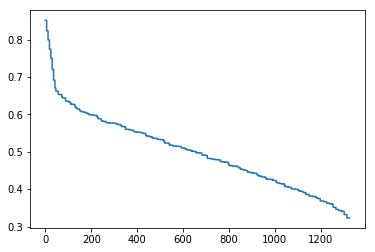

In [23]:
# preflop equity distribution of ATC vs ATC
pfBoard = pe.string2card(['__', '__', '__', '__', '__']) # preflop board
#pfEArray = EquityArray(pfBoard)
ATC = Range(1.0)
plotEqDistn(ATC, ATC, pfBoard)

When the equity distributions of the players are similar, the equity distribution is approximately a straight line.

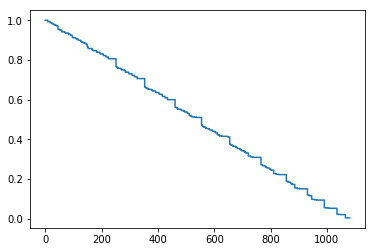

In [24]:
# Equity distribution on river
board = pe.string2card(['8d', '6s', '3h', 'Kd', 'Jd'])
range1 = Range(1.0)
range2 = Range(1.0)
plotEqDistn(range1, range2, board)

Range 1 with a significant advantage over Range 2. In this situation, even the worse hands in Range 1 have significant equity over Range 2.

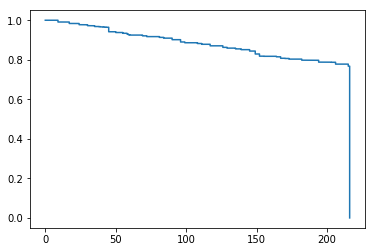

In [25]:
board = pe.string2card(['8d', '6s', '3h', 'Kd', 'Jd'])
range1 = Range(1.0)
range1.setToTop(0.2, board)
range2 = Range(1.0)
range2.setToTop(0.8, board)
plotEqDistn(range1, range2, board)

If we swap range 1 and range 2 we see the reflection across the diagonal.

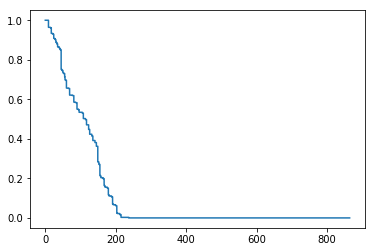

In [26]:
board = pe.string2card(['8d', '6s', '3h', 'Kd', 'Jd'])
range1 = Range(1.0)
range1.setToTop(0.2, board)
range2 = Range(1.0)
range2.setToTop(0.8, board)
plotEqDistn(range2, range1, board)

<h3> Solving the Shove-Fold Game </h3>
This is a simple game that is often analyzed for end of tournamnet situations. In this situation, the small blind (SB) can either shove or fold. The SB's strategy is defined by his jamming range and the BB's strategy is defined by his calling range. We will use the fictitious play algorithm to solve this simplified game.

In [27]:
# Input:
#    r1 - a Range object
#    r2 - a Range ojbect
#    n - a positive integer
# Output: n/a
# Side-effect:
#    Modifies r1 to incorporate some amount (depending on n) of r2.
#    In particular, the output of every hand in r1 at the end of the function
#    will be given by:
#    (original amount) * (fraction depending on n) + (new amount) * (1 - fraction)
#    where the fraction becomes closer to 1 the higher n is.
def updateRange(r1, r2, n):
    fraction = 1 - 1 / (n + 2.0)
    for i in range(numCards):
        for j in range(i+1, numCards):
            hand = [i, j]
            r1.setFrac(hand, (r1.getFrac(hand)) * fraction + (r2.getFrac(hand)) * (1-fraction))
            

In [28]:
# Input: n/a
# Output: n/a
# Side-effects: display SB shoving range and BB calling range
def doShoveFoldGame():
    
    nIter = 200 # number of iterations for fictious play
    S = 10 # stack size in BB
    ea = EquityArray(pe.string2card(['__', '__', '__', '__', '__']))
    
    # guess initial ranges
    sbJamRange = Range()
    sbJamRange.setAllFracs(0.5) # not a good guess, this is deliberate
    bbCallRange = Range()
    bbCallRange.setAllFracs(0.5)
    
    for n in range(nIter):
        #display(sbJamRange)
        #display(bbCallRange)
        
        # solve for SB maximally exploitative strategy
        bestSBJamRange = Range()
        for i in range(numCards):
            for j in range(i+1, numCards):
                hand = [i, j]
                
                # The expected value of jamming is given by
                # (chance BB folds) * (S+1) + (chance BB calls) * equity * 2 * S
                # but we need to be careful to account for card removal effects
                
                bb_call_freq = bbCallRange.getNumHandsWithoutConflicts(hand) / numVillainHands
                equity = getEquityVsRange(hand, bbCallRange, ea)
                evJam = (1 - bb_call_freq) * (S+1) + (bb_call_freq) * equity * 2 * S
                evFold = S - 0.5
                if (evJam > evFold):
                    bestSBJamRange.setFrac(hand, 1)
                else:
                    bestSBJamRange.setFrac(hand, 0)
        
        # update SB strategy
        updateRange(sbJamRange, bestSBJamRange, n)
        
        # solve for BB maximally exploitative strategy
        bestBBCallRange = Range()
        for i in range(numCards):
            for j in range(i+1, numCards):
                hand = [i, j]
                equity = getEquityVsRange(hand, sbJamRange, ea)
                evCall = 2 * S * equity
                evFold = S - 1
                if (evCall > evFold):
                    bestBBCallRange.setFrac(hand, 1)
                else:
                    bestBBCallRange.setFrac(hand, 0)
                    
        # update BB strat
        updateRange(bbCallRange, bestBBCallRange, n)
        

        
        
    display(sbJamRange)
    display(bbCallRange)

In [29]:
doShoveFoldGame()

In [36]:
# Future Work
# - tell computer how to visualize and work with decision trees
# - strategies for playing those decision trees (multiple ranges)
# - maximally exploitative strategies
# - use fictitious play to find approximate equilibria

In [37]:
# Decision Trees
# Create decision point object:
#    player - a string decribing whose decision point it is
#             one of "SB", "BB", "Nature", or "Leaf
#    initial_sb_cip - small blind chips in pot before any decision is made
#                     at this point
#    initial_bb_cip - like above but for BB
#    eArray - an EquitiesArray describing the current board
#    parentAction - string describing the action that got us to this point
#                   one of: "bet", "fold", "check", "call" or board cards
#    newCardFreq - only used if parent action was new cards being dealt
#                  we don't want all new cards to have equaly probability
#                  of falling
# COnnect those objects via tree (graph) structure

In [30]:
# DecPt - represents a decision point object:
#    player - a string decribing whose decision point it is
#             one of "SB", "BB", "Nature", or "Leaf
#    initial_sb_cip - small blind chips in pot before any decision is made
#                     at this point
#    initial_bb_cip - like above but for BB
#    eArray - an EquitiesArray describing the current board
#    parentAction - string describing the action that got us to this point
#                   one of: "bet", "fold", "check", "call" or board cards
#    newCardFreq - only used if parent action was new cards being dealt
#                  we don't want all new cards to have equaly probability
#                  of falling
class DecPt:
    def __init__(self, player, initial_sb_cip, initial_bb_cip, eArray, parent_action, newCardFreq = 1.0):
        self.player = player
        self.initial_sb_cip = initial_sb_cip
        self.initial_bb_cip = initial_bb_cip
        self.eArray = eArray
        self.parentAction = parentAction
        self.newCardFreq = newCardFreq
    
    # Input: player - a string that is either "SB" or "BB"
    # Output: chips in pot of player at beginning of decision point
    # Side-Effects: n/a
    def getPlayerCIP(self, player):
        if (player == "SB"):
            return sb_initial_cip
        elif (player == "BB"):
            return bb_initial_cip
        else:
            print "ERROR: DecPt.getPlayerCIP given invalid player: " + player

In [31]:
# A simple approach to a tree structure:
# Put all our decision points in a list (implicit numbering of them)
# Then, we need to keep track of parent/child relationships using two more arrays.
#    decPoints - name of this list
#    parents - the ith element of this array will contain the number of the
#              point which is the ith poin's parent. i.e. if we want to know
#              the ith point's parent, we access parent[i]
#    children - the ith element of this array will contain another array
#               containing the numbers of points which are the ith point's
#               children. i.e. if we want to know the ith point's children
#               we access children[i].
# Example:
#                 0       1       2       3       4
#     decPts: [pointA, pointB, pointC, pointD, pointE]
# children: [[], [], [], [1, 2], [0, 3]]
# parents: [4, 3, 3, 4, None]
# Note: we only need one list to tell us about parent/child relationships
#       because we can infer this relationship from one or the other
#       Nevertheless, storing them is more convenient than searching the whole
#       tree each time we need the other.

# When we make a new tree, we'll just gie it an effective stack size S,
# and a first decision point (called the root).
# Later, we will add additional decision points.
#
class Tree:
    def __init__(self, S, root):
        self.effStack = S
        self.decPts = [] # list of all decision pts in the tree
        self.children = []
        self.parents = []
        self.addDecPt(root, None) # (node, parents)
        
        
    # Inputs: n/a
    # Outputs: the number of decision points in the tree
    # Side-effects: n/a
    def getNumPoints(self):
        return len(self.decPts)
    
    # Inputs: n/a
    # Outputs: Effective stack at the beginning of the decision tree
    #          (corresponds to the beginning of the hand, i.e. neither player
    #           has money in the pot. No blinds, no bets made.)
    # Side-effects: n/a
    def getEffectiveStack(self):
        return self.effStack
        
    # Inputs:
    #    point: the new point (not previously in the tree)
    #    parent: a decision point already in the tree
    # Outputs: n/a
    # Side-effects: adds a new decision point to the tree
    def addDecPt(self, point, parents):
        self.decPts.append(point)
        self.children.append([])
        if (parent == None): # only true for the root node
            self.parents.append(None)
        else:
            parentIndex = self.decPts.index(parent)
            self.children[parentIndex].append(self.getNumPoints() - 1 )
            self.parents.append(parentIndex)

to be continued...

Future work
- rewrite above to follow normal naming conventions
- move bulk of comments into docstrings
- develop graph visualization techniques
- solve more complex games